# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

import evidently
import shap

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics, preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)

In [3]:
# load cleaned data
app_train = pd.read_pickle("../data/processed/app_train_cleaned.pkl")
app_test = pd.read_pickle(
    "../data/processed/app_test_cleaned.pkl"
)  # used for datadrift only

In [4]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 244 entries, SK_ID_CURR to FE_PAYMENT_RATE
dtypes: bool(130), float64(71), int64(43)
memory usage: 305.6 MB


# Split train/test
To keep some test data not seen by gridsearch

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    app_train.drop("TARGET", axis=1), app_train.TARGET, test_size=0.15
)

## Naive undersampler to fix target imbalance

In [6]:
def NaiveUnderSampler(df):
    # find the minority class
    min_class = df.TARGET.value_counts().idxmin()
    # keep same number of majority class than minority
    target_minority_count = df[df.TARGET == min_class].shape[0]
    df_balanced = pd.concat(
        [
            df[df.TARGET == min_class].sample(target_minority_count),
            df[df.TARGET != min_class].sample(target_minority_count),
        ]
    )
    # shuffle rows
    return df_balanced.sample(frac=1)

In [7]:
# create transformer with fit methods from my function
NaiveUnderSamplerTf = FunctionTransformer(NaiveUnderSampler)

In [8]:
# test naive imbalance fixer
app_train.pipe(NaiveUnderSampler).TARGET.value_counts()

TARGET
1    24825
0    24825
Name: count, dtype: int64

# Pipeline

In [16]:
# separate target
# X, y = app_train.drop("TARGET", axis=1), app_train.TARGET
# print(X.shape)
# print(y.shape)

In [9]:
samplerList = [NaiveUnderSamplerTf, RandomUnderSampler()]
pipe = Pipeline(
    [
        ("sampler", RandomUnderSampler()),
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler()),
        ("classifier", LogisticRegression(max_iter=500)),
    ]
)
pipe

Pipeline(steps=[('sampler', RandomUnderSampler()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(max_iter=500))])

In [10]:
grid = GridSearchCV(pipe, param_grid={}, cv=3, n_jobs=-1, verbose=3, scoring="roc_auc")
grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1, param_grid={}, scoring='roc_auc', verbose=3)

In [11]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.82427,0.081661,0.525522,0.013289,{},0.744069,0.741312,0.746579,0.743987,0.002151,1


In [12]:
y_pred = grid.predict(X_test)

In [13]:
y_pred.shape

(46127,)

In [14]:
X_train.shape

(261384, 243)

# Proba predict treshold

In [ ]:
# faire varier seuil et afficher graphiquement resultats

In [15]:
# # Make the model with the specified regularization parameter
# log_reg = LogisticRegression(max_iter=500)
# dummy = DummyClassifier()

# # Train on the training data
# log_reg.fit(X_train, y_train)
# # dummy.fit(X_train, y_train)

In [16]:
# y_pred = log_reg.predict(X_test)

In [17]:
# y_pred

# Scoring metric

In [18]:
y_pred.mean()

0.35083573611984303

In [19]:
metrics.accuracy_score(y_test, y_pred)

0.6789949487285104

Sensibilité : 1.00
Spécificité : 0.00
Seuil : 0.00


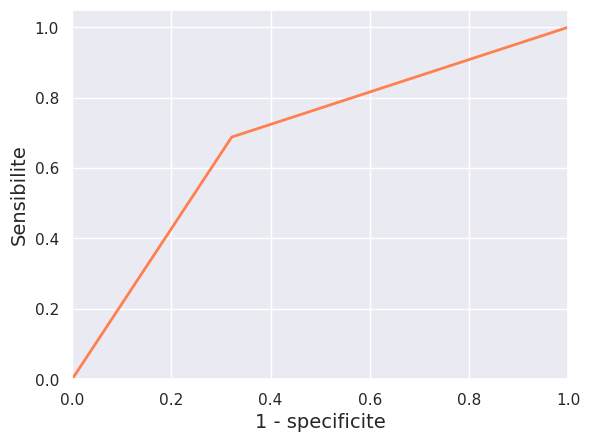

In [20]:
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color="coral", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("1 - specificite", fontsize=14)
plt.ylabel("Sensibilite", fontsize=14)

# indice du premier seuil pour lequel
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95))

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1 - fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

# Profits and Loss function

In [21]:
def human_format(num):
    num = float("{:.3g}".format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return "{}{}".format(
        "{:f}".format(num).rstrip("0").rstrip("."), ["", "K", "M", "B", "T"][magnitude]
    )

In [40]:
# compute mean ratio of value of goods, and amount loaned for buying this goods
GOODS_CREDIT_RATIO = (
    app_train[app_train["AMT_GOODS_PRICE"].notna()].AMT_GOODS_PRICE
    / app_train[app_train["AMT_GOODS_PRICE"].notna()].AMT_CREDIT
).mean()


def pnl(y_pred, y_true, X, interest=0.04, goods_recover_rate=0.60):
    # ajouter type casting
    # todo X en param
    # df.apply(pnl)
    # y_proba
    # interest  et GOODS_P en param
    # INTEREST = 0.04
    # GOODS_RECOVER_RATE = 0.60
    credit = app_train.loc[X_test.index, "AMT_CREDIT"]
    # when goods value is missing, use 90% of credit amount
    seized_goods = (
        np.where(
            app_train.loc[X_test.index, "AMT_GOODS_PRICE"].notna(),
            app_train.loc[X_test.index, "AMT_GOODS_PRICE"],
            app_train.loc[X_test.index, "AMT_CREDIT"] * GOODS_CREDIT_RATIO,
        )
        * GOODS_RECOVER_RATE
    )
    pnl = pd.Series(np.nan)
    # TP : pret refusé correctement = pas de perte
    pnl = np.where((y_pred == 1) & (y_true == 1), 0, pnl)
    # FP : pret refusé par erreur : perte des interets
    pnl = np.where(
        (y_pred == 1) & (y_true == 0),
        -credit * INTEREST,
        pnl,
    )
    # TN : pret accordé correctement : gain des interets
    pnl = np.where(
        (y_pred == 0) & (y_true == 0),
        credit * INTEREST,
        pnl,
    )
    # FN : pret accordé par erreur : perte du montant du pret et des interets
    pnl = np.where(
        (y_pred == 0) & (y_true == 1),
        -credit * (1 + INTEREST) + seized_goods,
        pnl,
    )
    return pnl.sum()

In [23]:
print("P&L avec prédictions modèle : $", human_format(pnl(y_pred, y_test)))
print("P&L avec prédictions parfaites : $", human_format(pnl(y_test, y_test)))

P&L avec prédictions modèle : $ -181M
P&L avec prédictions parfaites : $ 383M


In [24]:
y_pred.mean()

0.35083573611984303

In [25]:
y_test.mean()

0.07930279445877686

## Essai non concluant : calculer intérêts et durée du prêt en fonction du montant total et de l'annuity

In [26]:
app_train[["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]].sample(10)

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
157203,625536.0,22599.0,540000.0
166401,592560.0,32274.0,450000.0
256092,202500.0,7762.5,202500.0
242550,152820.0,18265.5,135000.0
197163,948582.0,27864.0,679500.0
52017,728460.0,57685.5,675000.0
103622,215640.0,15138.0,180000.0
201701,142200.0,8293.5,112500.0
21927,104256.0,11074.5,90000.0
196208,152820.0,16344.0,135000.0


In [27]:
(app_train.AMT_ANNUITY / app_train.AMT_CREDIT).describe()

# app_train.AMT_CREDIT * 1.0665 / app_train.AMT_ANNUITY

count    307499.000000
mean          0.053695
std           0.022481
min           0.022073
25%           0.036900
50%           0.050000
75%           0.064043
max           0.124430
dtype: float64

# Shap values

In [28]:
explainer = shap.LinearExplainer(grid.best_estimator_["classifier"], X_train)
shap_values = explainer.shap_values(X_test)
shap_values

array([[4269.624295196911, -0.12929276140809623, 0.06434807643876354,
        ..., -10253.208342244256, -0.08600777821909113,
        0.0038251050783658976],
       [-3864.5339119393557, 0.011242848818095324, 0.06434807643876354,
        ..., -23500.247544110218, 0.034295035781130336,
        0.022296628747341847],
       [-1706.5232455547614, 0.011242848818095324, 0.06434807643876354,
        ..., -1421.8488743336134, 0.014855034375817143,
        0.021790993877067403],
       ...,
       [2847.8937919218665, 0.011242848818095324, 0.06434807643876354,
        ..., -21733.97565052809, 0.134877751479636, 0.02217271985118214],
       [686.4905372386268, 0.011242848818095324, -0.13064609458779264,
        ..., -1421.8488743336134, -0.016563697832630404,
        -0.0560435596818566],
       [-4695.275533590327, 0.011242848818095324, 0.06434807643876354,
        ..., 7409.510593577028, -0.0956070419974579, 0.01895235281747627]],
      dtype=object)

In [29]:
X_test.shape

(46127, 243)

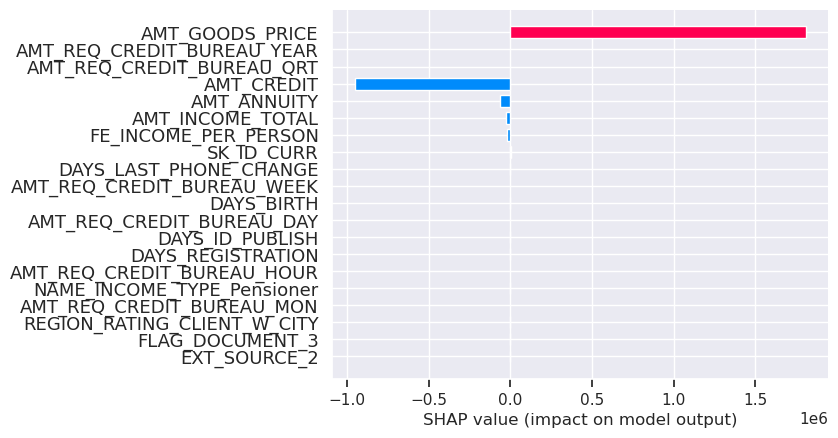

In [46]:
# explainer for only 1 sample row
shap.bar_plot(
    explainer.shap_values(X_test.sample(1))[0],
    feature_names=X_test.columns,
    max_display=20,
)

In [228]:
# shap.plots.beeswarm(explainer.shap_values(X_test))

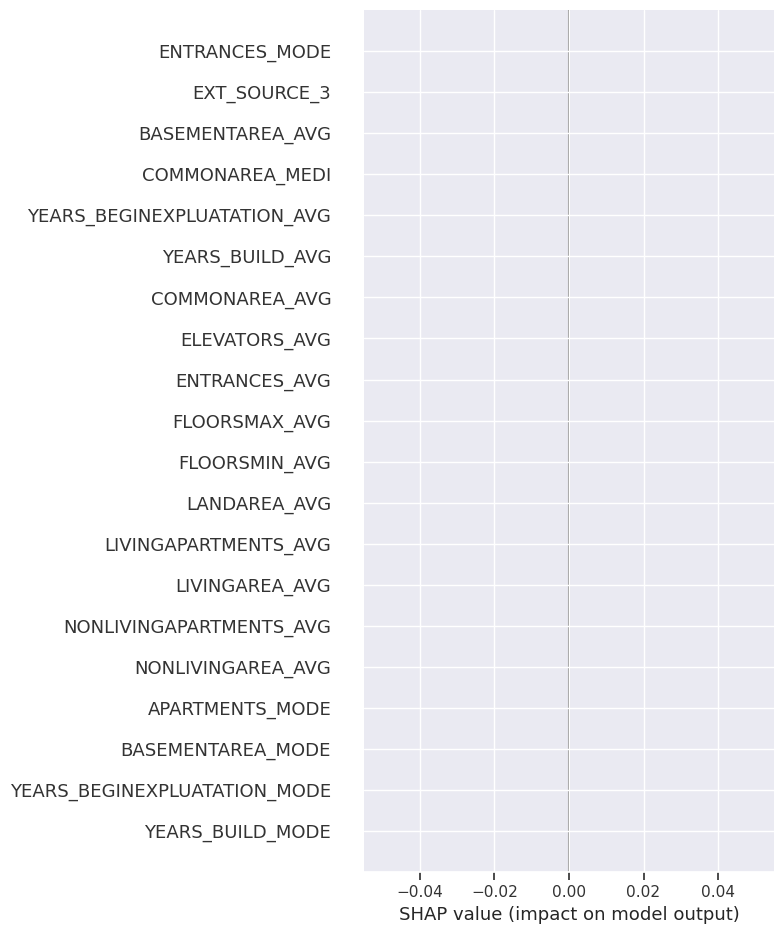

In [42]:
shap.summary_plot(
    explainer.shap_values(X_test).astype(float),
    feature_names=X_test.columns,
    # use_log_scale=True,
)

# Data Drift
Pour simuler évolution des commportements utilisateurs dans le temps, on fait l'hypothèse que `app_train` représente les données d'entrainement et `app_test` les données de test.  
On applique le même nettoyage à train et test

In [32]:
from evidently.metric_preset import DataDriftPreset
from evidently.report import Report

data_drift_report = Report(
    metrics=[
        DataDriftPreset(),
    ]
)

data_drift_report.run(
    reference_data=app_train.sample(frac=0.05).drop("TARGET", axis=1),
    current_data=app_test.sample(frac=0.05),
    # column_mapping=None,
)

data_drift_report.save_html("../reports/data_drift_report.html")

In [41]:
! firefox ../reports/data_drift_report.html

Gtk-Message: 16:42:36.333: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
